In [1]:
%matplotlib inline
import imp
import os
import pickle
import seaborn as sb
import random
import warnings
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

warnings.filterwarnings("ignore")
plt.style.use('ggplot')

# Path to folder containing wrapper modules
wrapper_fpath = (r"..\inca.py")
optimize_funs_fpath = (r'..\inca_calibration.py')
emcee_Morsa_fpath = (r'simplyp_emcee_Morsa.py')

wr = imp.load_source('inca',wrapper_fpath)
cf = imp.load_source('inca_calibration', optimize_funs_fpath)
em = imp.load_source('simplyp_emcee_Morsa.py', emcee_Morsa_fpath)

# Plot MCMC results

## 1. Initialise wrapper and load MCMC output

In [2]:
# Setup used to run emcee
wr.initialize('simplyp.dll')

dataset = wr.DataSet.setup_from_parameter_and_input_files('../../Applications/SimplyP/Morsa/MorsaParameters.dat',
                                                          '../../Applications/SimplyP/Morsa/MorsaInputs.dat')

# Unpack options from pickled file
with open('pickled\\mcmc_settings.pkl', 'rb') as handle:
    settings_dict = pickle.load(handle)

comparisons = settings_dict['comparisons']
skiptimesteps = settings_dict['skiptimesteps']
calibration = settings_dict['calibration']
n_ms = settings_dict['n_ms']
minval = settings_dict['param_min']
initial_guess = settings_dict['initial_guess']
maxval = settings_dict['param_max']
labels_short = settings_dict['labels_short']
labels_long = settings_dict['labels_long']
n_walk = settings_dict['n_walk']
n_steps = settings_dict['n_steps']
n_burn = settings_dict['n_burn']

n_comparisons = len(comparisons)   

objective = (cf.log_likelyhood, comparisons, skiptimesteps)

# Read in the emcee results and reshape
with open('pickled\\emcee_results_morsa_v3.pkl', 'rb') as handle:
    samp, lnprob = pickle.load(handle)
    
samplelist, lnproblist = em.reshape_samples(samp, lnprob, n_burn)

## 2. Sample from posterior

In [3]:
# User input
n_random_samples = 1000
varlist = ['Q','SS','TP','TDP','PP']

In [4]:
def do_n_random_simulations_from_sample_list(dataset, samplelist, calibration, objective, n_samples, var_list, n_ms) :

    llfun, comparisons, skiptimesteps = objective

    for i, tup in enumerate(comparisons):
        simname, simindexes, obsname, obsindexes = comparisons[i]
   
    # Set up for looping over param sets
    var_simDict_paramOnly = {} # Keys: list of variables. Must be same length as comparisons
                               # Returns: List of simulated results (each element a 1D array of model output)
    var_simDict_overall = {}
    
    for i in var_list:
        var_simDict_paramOnly[i] = []
        var_simDict_overall[i] = []
    
    # Loop over param sets in sample list
    for it in range(1, n_samples) :       #TODO: Should be paralellized, really..

        random_index = random.randint(0, len(samplelist)-1)
        random_sample = samplelist[random_index]

        cf.set_values(dataset, random_sample, calibration, n_ms)
        dataset.run_model()
        
        for i, tup in enumerate(comparisons):
            
            simname, simindexes, obsname, obsindexes = comparisons[i]
            sim = dataset.get_result_series(simname, simindexes)
            
            var_simDict_paramOnly[var_list[i]].append(sim)

            if i<3: # Q, SS, TP
                M = random_sample[len(calibration)-n_ms+i]
            else: # TDP, PP same as TP
                M = random_sample[-1]
            stoch = norm.rvs(loc=0, scale=M*sim, size=len(sim))
            perturbed = sim + stoch

            var_simDict_overall[var_list[i]].append(perturbed)

    return(var_simDict_paramOnly, var_simDict_overall)

# Generate samples
var_simDict_paramOnly, var_simDict_overall = do_n_random_simulations_from_sample_list(dataset,
                                                                                      samplelist, 
                                                                                      calibration, 
                                                                                      objective, 
                                                                                      n_random_samples, 
                                                                                      varlist,
                                                                                      n_ms)

## 3. Plot percentiles

In [5]:
# User input
perc = [25, 50, 75]
#var = 'PP'

# Plot styling
var_idx_dict = {'Q':0, 
                'SS':1, 
                'TP':2, 
                'TDP':3,
                'PP':4}

ylab_dict = {'Q':'Q (m$^3$/s)', 
             'SS':'Suspended sediment (mg/l)', 
             'TP':'Total P (mg/l)',
             'TDP':'Total dissolved P (mg/l)',
             'PP':'Particulate P (mg/l)'}

ymax_dict = {'Q':80, 
             'SS':300, 
             'TP':0.5, 
             'TDP':0.2,
             'PP':0.5}

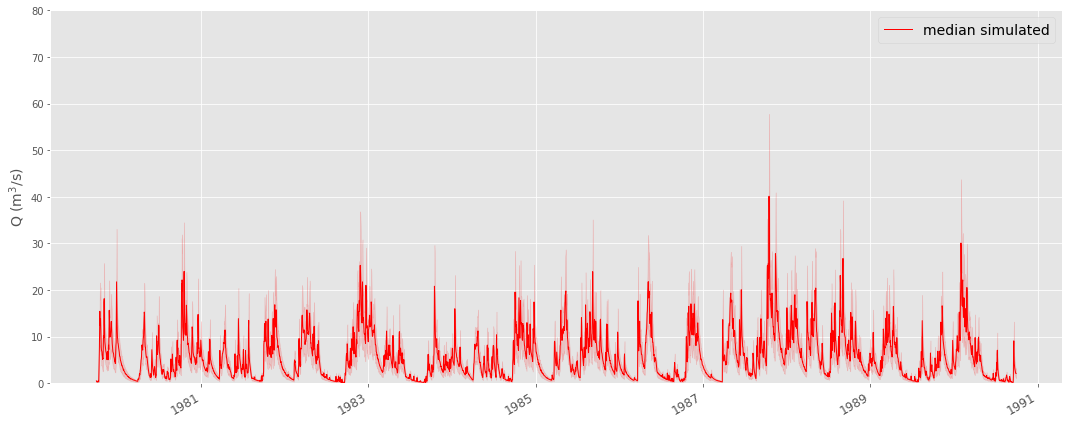

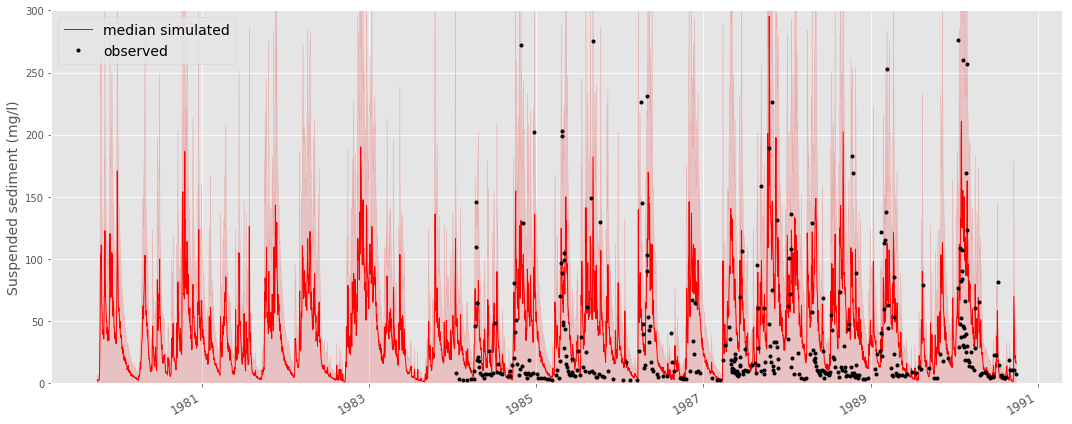

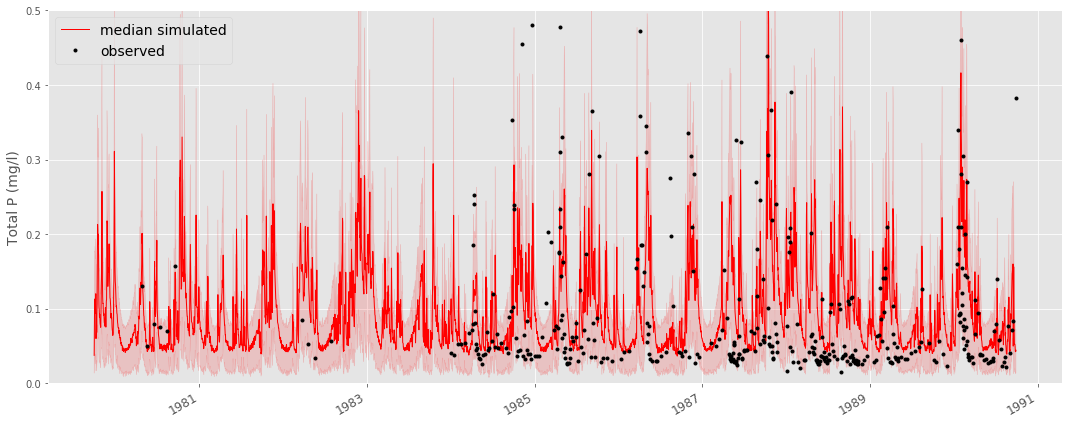

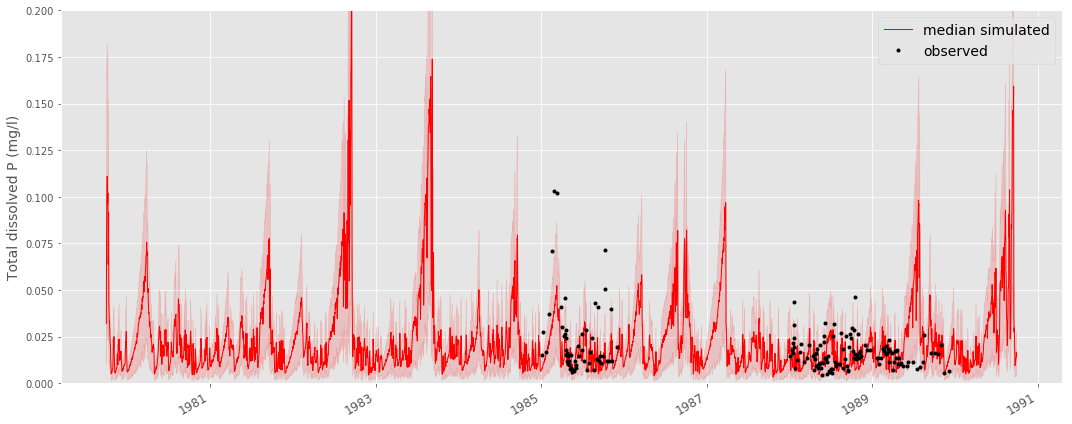

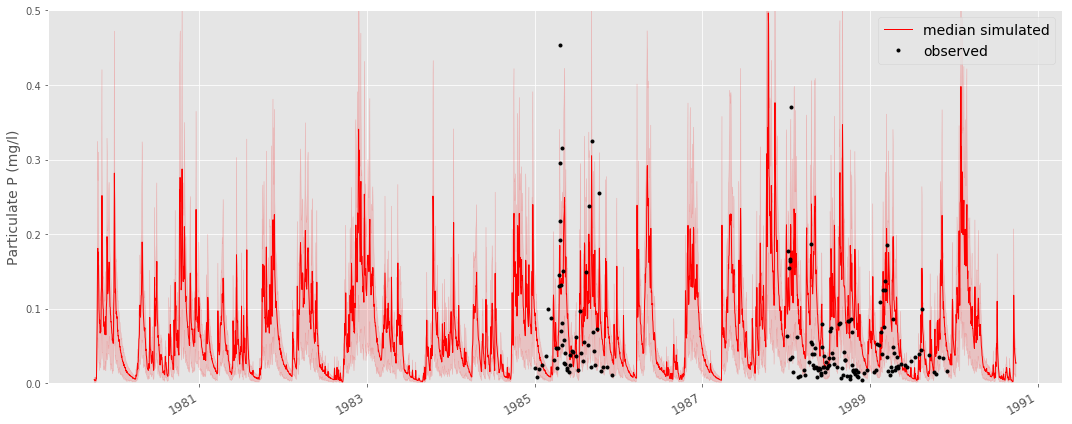

In [6]:
def plot_percentiles(dataset, simulationresults, calibration, objective,
                     comparison_idx, perc, filename, ylab, ymax) :

    llfun, comparisons, skiptimesteps = objective
    comparisontolookat = comparisons[comparison_idx] 
    simname, simindexes, obsname, obsindexes = comparisontolookat

    percentiles = np.percentile(simulationresults, perc, axis=0)

    fig, ax = plt.subplots(figsize=(15,6))

    start_date = dt.datetime.strptime(dataset.get_parameter_time('Start date', []),'%Y-%m-%d')
    timesteps = dataset.get_parameter_uint('Timesteps', [])
    date_idx = np.array(pd.date_range(start_date, periods=timesteps))

    ax.plot(date_idx, percentiles[1], color='red', label='median simulated', lw=1)
    ax.fill_between(date_idx, percentiles[0], percentiles[2], color='red', alpha=0.15)

    obs = dataset.get_input_series(obsname, obsindexes, True)

    # If lots of missing data in obs (i.e. not daily), plot as scatter too
    if len(obs[~np.isnan(obs)])< 0.5*len(percentiles[1]):
        marker='o'
        ax.plot(date_idx, obs, color = 'black', marker='o', ms=3, ls='None', label = 'observed')
#         ax.plot(date_idx, obs, color = 'black', lw=1)

#     else:
#         ax.plot(date_idx, obs, color = 'black', label = 'observed', lw=1)

    plt.ylim(bottom=0, top=ymax) # Stochastic error may cause negative flows; mask for now (N.B. need to revisit)

    ax.legend(fontsize=14)

    plt.setp(ax.get_xticklabels(), visible=True, rotation=30, ha='right', fontsize=12)
    plt.ylabel(ylab, fontsize=14)
    
    plt.tight_layout()
    plt.savefig(fig_fpath, dpi=300)

    return (fig, ax)

for var in varlist:
    comparison_idx = var_idx_dict[var]
    ylab = ylab_dict[var]
    ymax = ymax_dict[var]
    fig_fpath = r'simplyp_plots/timeseries_%s_1980-1990_with_uncertainty.png' % var
    
    fig, ax = plot_percentiles(dataset, var_simDict_overall[var], calibration, objective,
                               comparison_idx, perc, fig_fpath, ylab, ymax)

## 4. Goodness-of-fit statistics

In [7]:
em.GoF_stats_single_sample(samplelist, lnproblist, dataset, calibration, objective, n_ms)


Best sample (max log likelihood):

Goodness of fit for Reach flow (daily mean, cumecs) [Kure] vs Observed Q []:
Mean error (bias): -0.054237
Mean absolute error: 2.165821
Mean square error: 13.806781
Nash-Sutcliffe coefficient: 0.613755
Number of observations: 2069


Goodness of fit for Reach suspended sediment concentration [Kure] vs Observed SS at Kure []:
Mean error (bias): -0.858232
Mean absolute error: 71.119522
Mean square error: 28842.103059
Nash-Sutcliffe coefficient: 0.102418
Number of observations: 404


Goodness of fit for Reach TP concentration [Kure] vs Observed TP at Kure []:
Mean error (bias): 0.012243
Mean absolute error: 0.089097
Mean square error: 0.022196
Nash-Sutcliffe coefficient: 0.145755
Number of observations: 415


Goodness of fit for Reach TDP concentration [Kure] vs Observed TDP at Kure []:
Mean error (bias): -0.003031
Mean absolute error: 0.008779
Mean square error: 0.000180
Nash-Sutcliffe coefficient: 0.071274
Number of observations: 173


Goodness of fit 

## 5. Validation statistics

Needs tidying.

In [8]:
# Extract best parameter set and run model with that for varioius time periods, extracting
# GoF statistics

# Original param set: "1979-10-01" for 4017 days (11 yrs), i.e. to 30/09/1990

# Set best param set to model dataset
best_sample = em.best_sample(samplelist, lnproblist)
cf.set_values(dataset, best_sample, calibration, n_ms)

# NOTE!!!: looking at the 'best', and all the 'insensitive' param values
# are unaltered in the file compared to the manual calibration
# NEEDS DEBUGGING!!!
dataset.write_parameters_to_file('Morsa_emcee_best_parameters_v3.dat')

# NOTE: for some reason code below isn't working, get an access violation error whenever I
# try to access an input series after resetting the date params. Clunky workaround for now:
# write params to file, manually change start date and time steps, then in next cell
# read back in and do GoF...

# # Reset start date and timesteps and realign input data
# dataset.set_parameter_time('Start date', [], start_date)
# dataset.set_parameter_uint('Timesteps',[],timesteps)

# # Align inputs with new start date and time steps
# model_inputs = [i[0] for i in dataset.get_input_list()]
# for variable in model_inputs:
#     series = dataset.get_input_series(variable,[], True)
#     dataset.set_input_series(variable, [], series, True)

# # Run and extract simulated output
# dataset.run_model()

# cf.print_goodness_of_fit(dataset, objective)

In [9]:
# For comparison with INCA-P results in MARS project (they calibrated to this period)
# They started in Jan 1983; went back little bit here for hydrol year/snow
start_date = "1982-10-01"
timesteps = 11779 # 31/12/2014

dataset.delete()
dataset = wr.DataSet.setup_from_parameter_and_input_files('Morsa_emcee_best_parameters_v3.dat',
                                                          '../../Applications/SimplyP/Morsa/MorsaInputs.dat')
dataset.run_model()
cf.print_goodness_of_fit(dataset, objective)


Goodness of fit for Reach flow (daily mean, cumecs) [Kure] vs Observed Q []:
Mean error (bias): -0.054237
Mean absolute error: 2.165821
Mean square error: 13.806781
Nash-Sutcliffe coefficient: 0.613755
Number of observations: 2069


Goodness of fit for Reach suspended sediment concentration [Kure] vs Observed SS at Kure []:
Mean error (bias): -0.858232
Mean absolute error: 71.119522
Mean square error: 28842.103059
Nash-Sutcliffe coefficient: 0.102418
Number of observations: 404


Goodness of fit for Reach TP concentration [Kure] vs Observed TP at Kure []:
Mean error (bias): 0.012243
Mean absolute error: 0.089097
Mean square error: 0.022196
Nash-Sutcliffe coefficient: 0.145755
Number of observations: 415


Goodness of fit for Reach TDP concentration [Kure] vs Observed TDP at Kure []:
Mean error (bias): -0.003031
Mean absolute error: 0.008779
Mean square error: 0.000180
Nash-Sutcliffe coefficient: 0.071274
Number of observations: 173


Goodness of fit for Reach PP concentration [Kure] v

In [10]:
# Validation
start_date = "1990-10-01"
timesteps = 8765 # 30/09/2014 (24 yrs)

dataset.delete()
dataset = wr.DataSet.setup_from_parameter_and_input_files('Morsa_emcee_best_parameters_v3.dat',
                                                          '../../Applications/SimplyP/Morsa/MorsaInputs.dat')
dataset.run_model()
cf.print_goodness_of_fit(dataset, objective)


Goodness of fit for Reach flow (daily mean, cumecs) [Kure] vs Observed Q []:
Mean error (bias): -0.054237
Mean absolute error: 2.165821
Mean square error: 13.806781
Nash-Sutcliffe coefficient: 0.613755
Number of observations: 2069


Goodness of fit for Reach suspended sediment concentration [Kure] vs Observed SS at Kure []:
Mean error (bias): -0.858232
Mean absolute error: 71.119522
Mean square error: 28842.103059
Nash-Sutcliffe coefficient: 0.102418
Number of observations: 404


Goodness of fit for Reach TP concentration [Kure] vs Observed TP at Kure []:
Mean error (bias): 0.012243
Mean absolute error: 0.089097
Mean square error: 0.022196
Nash-Sutcliffe coefficient: 0.145755
Number of observations: 415


Goodness of fit for Reach TDP concentration [Kure] vs Observed TDP at Kure []:
Mean error (bias): -0.003031
Mean absolute error: 0.008779
Mean square error: 0.000180
Nash-Sutcliffe coefficient: 0.071274
Number of observations: 173


Goodness of fit for Reach PP concentration [Kure] v

In [11]:
# Previous period I was playing with (and getting NS of around 0.7-8 for Q)
start_date = "2007-10-01"
timesteps = 730 # 30/09/2014 (24 yrs)

dataset.delete()
dataset = wr.DataSet.setup_from_parameter_and_input_files('Morsa_emcee_best_parameters_v3.dat',
                                                          '../../Applications/SimplyP/Morsa/MorsaInputs.dat')
dataset.run_model()
cf.print_goodness_of_fit(dataset, objective)


Goodness of fit for Reach flow (daily mean, cumecs) [Kure] vs Observed Q []:
Mean error (bias): -0.054237
Mean absolute error: 2.165821
Mean square error: 13.806781
Nash-Sutcliffe coefficient: 0.613755
Number of observations: 2069


Goodness of fit for Reach suspended sediment concentration [Kure] vs Observed SS at Kure []:
Mean error (bias): -0.858232
Mean absolute error: 71.119522
Mean square error: 28842.103059
Nash-Sutcliffe coefficient: 0.102418
Number of observations: 404


Goodness of fit for Reach TP concentration [Kure] vs Observed TP at Kure []:
Mean error (bias): 0.012243
Mean absolute error: 0.089097
Mean square error: 0.022196
Nash-Sutcliffe coefficient: 0.145755
Number of observations: 415


Goodness of fit for Reach TDP concentration [Kure] vs Observed TDP at Kure []:
Mean error (bias): -0.003031
Mean absolute error: 0.008779
Mean square error: 0.000180
Nash-Sutcliffe coefficient: 0.071274
Number of observations: 173


Goodness of fit for Reach PP concentration [Kure] v